In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

# Set matplotlib and seaborn plotting style
sns.set_style('darkgrid')
np.random.seed(42)

In [6]:
def exp_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)
    

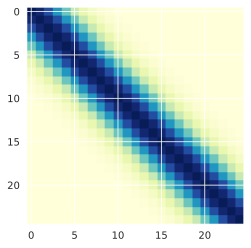

In [24]:
X = np.expand_dims(np.linspace(*xlim, 25), 1)
Σ = exp_quadratic(X, X)
plt.imshow(Σ, cmap=cm.YlGnBu);

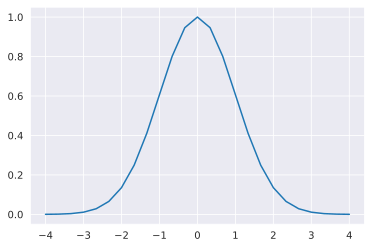

In [25]:
zero = np.array([[0]])
Σ0 = exp_quadratic(X, zero)
plt.plot(X[:,0], Σ0[:,0]);

### Sampling from prior

In [32]:
n_samples = 100
n_funcs = 8

X = np.expand_dims(np.linspace(-4,4, n_samples), 1)
Σ = exp_quadratic(X, X)

ys = np.random.multivariate_normal(mean=np.zeros(n_samples), cov=Σ, size=n_funcs)

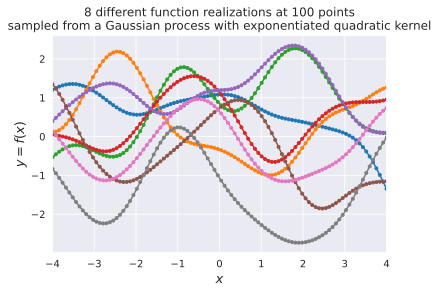

In [33]:
for i in range(n_funcs):
    plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title((
    f'{n_funcs} different function realizations at {n_samples} points\n'
    'sampled from a Gaussian process with exponentiated quadratic kernel'))
plt.xlim([-4, 4])
plt.show()

In [35]:
exponentiated_quadratic = exp_quadratic

In [74]:
A = np.array([[1,-2j],[2j,5]])
A, A.shape

(array([[ 1.+0.j, -0.-2.j],
        [ 0.+2.j,  5.+0.j]]),
 (2, 2))

In [75]:
L = np.linalg.cholesky(A)

In [77]:
np.dot(L, L.T.conj())

array([[1.+0.j, 0.-2.j],
       [0.+2.j, 5.+0.j]])

In [78]:
A = [[1,-2j],[2j,5]] # what happens if A is only array_like?
np.linalg.cholesky(A) # an ndarray object is returned

array([[1.+0.j, 0.+0.j],
       [0.+2.j, 1.+0.j]])

In [80]:
np.linalg.cholesky(np.matrix(A))

matrix([[1.+0.j, 0.+0.j],
        [0.+2.j, 1.+0.j]])

In [ ]:
def GP(X1, y1, X2, kernel_func):
    cov11 = kernel_func(X1, X1)
    cov12 = kernel_func(X1, X2)
    solved = scipy.linalg.solve(cov11, cov12, assume_a='pos').T
    
    mu2 = solved @ y1
    cov22 = kernel_func(X2, X2)
    cov2 = cov22 - (solved @ cov12)
    return mu2, cov2
    

### TODO: Convert K-1 by using cholesky
https://jaketae.github.io/study/gaussian-process/

In [121]:
def GP2(X1, y1, X2, kernel_func):
    K11 = kernel_func(X1, X1)
    K12 = kernel_func(X1, X2)
    K22 = kernel_func(X2, X2)
    
    #L = np.linalg.cholesky(K11)    
    mu2 = K12.T.dot(np.linalg.inv(K11)).dot(y1)
    cov2 = K22 - K12.T.dot(np.linalg.inv(K11)).dot(K12)
    return mu2, cov2

In [122]:
ny = 10 # Number of functions
domain = (-6, 6)
domain[0]+2, domain[1]-2, (n1, 1)
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
X1.shape

(50, 1)

In [131]:
%%prun
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 40 # Train points
n2 = 75 # Test points
ny = 5 # Number of functions
domain = (-6, 6)

X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_sin(X1)

X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)

# mu2, cov2 = GP(X1, y1, X2, exp_quadratic)
mu2, cov2 = GP2(X1, y1, X2, exp_quadratic)
sigma2 = np.sqrt(np.diag(cov2))

y2 = np.random.multivariate_normal(mean=mu2, cov=cov2, size=ny)

<string>:16: RuntimeWarning: invalid value encountered in sqrt
<string>:18: RuntimeWarning: covariance is not positive-semidefinite.


         296 function calls (287 primitive calls) in 0.044 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.040    0.020    0.040    0.020 linalg.py:476(inv)
        1    0.001    0.001    0.001    0.001 linalg.py:1482(svd)
        3    0.001    0.000    0.001    0.000 3828527866.py:1(exp_quadratic)
        1    0.000    0.000    0.002    0.002 {method 'multivariate_normal' of 'numpy.random.mtrand.RandomState' objects}
        3    0.000    0.000    0.000    0.000 {built-in method scipy.spatial._distance_pybind.cdist_sqeuclidean}
        1    0.000    0.000    0.044    0.044 {built-in method builtins.exec}
     17/8    0.000    0.000    0.042    0.005 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.000    0.000    0.000    0.000 {method 'flatten' of 'numpy.ndarray' objects}
        4    0.000    0.000    0.000    0.000 {method 'dot' of 'numpy.ndarray' objects}
        1  

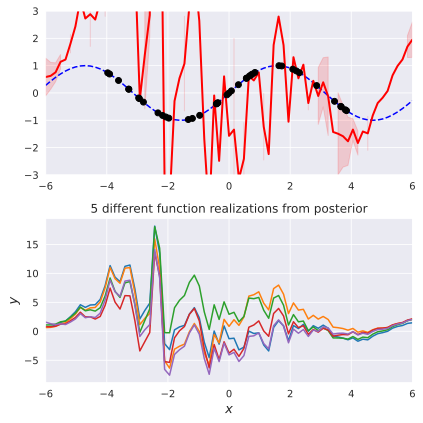

In [138]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))

# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, mu2-2*sigma2, mu2+2*sigma2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(X2, mu2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')

# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()